# 8. Proximity Calculations

Phew! We're going to continue building off what we've learned!

- [5.1 Introduction  ](#section1)
- [5.2 Proximity Analysis ](#section2)
    - Load and Prepare the Permit data
    - Create Buffer Polygons around Permit Points
    - Load and Prepare the BART stations Data
    - Spatial Join
    - Count the number of BART stations within walking distance
- [5.3 Exploratory Analysis ](#section3)
   - Map overlays
   - Interactive mapping
- [5.4 Recap](#section4)
- [5.5 Homework](#section5)

**INSTRUCTOR NOTES**:
- Datasets used:
    - "../notebook_data/outdata/tracts_and_permits_gdf.json"
    - "../notebook_data/outdata/permits_and_tracts_gdf.json"
    

- Expected time to complete:
    - Lecture + Questions: 45 minutes
    - Homework: 45 minutes

### Set-Up
Let's import the packages we need before we get started.

In [1]:
import math
import numpy as np
import pandas as pd
import collections
import requests 
from urllib.request import urlopen, Request

import json # for working with JSON data
import geojson # ditto for GeoJSON data - an extension of JSON with support for geographic data
import geopandas as gpd
# import mapclassify # to classify data values

import matplotlib # base python plotting library
%matplotlib inline  
import matplotlib.pyplot as plt # more plotting stuff

# import folium # popular python web mapping tool for creating Leaflet maps
# import folium.plugins
# from folium.plugins import MeasureControl

In [2]:
# We are getting futurewarning errors about the syntax of CRS definitions, ie "init=epsg:4269" vs "epsg:4269"
# so suppress as these are minor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id="section2"></a>
## 5.2 Proximity Analysis Buffers

Proximity analysis is a key part of spatial analysis. It considers what is nearby, in accordance with [Tobler's first law of geography](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography) which we paraphrase as "*Everything is related but nearby things are more related*."

In practice, distance-based buffer polygons around geospatial features are often used to examine proximal relationships. For example, one may want to consider how many parks are within walking distance of schools in order to identify underserved schools. This could be implemented using the following "recipe":

1. define walking distance, eg 500 meters or 1/3 mile
2. create buffer polygons around park features with a radious of `walking distance`
3. use a spatial join to associate schools with parks
4. count the number of parks with the school buffers.

Buffers can take on different shapes according to your original geometries ("input"). Putting a buffer around these can result in what you see in the second row of the image. The third row would result if we decided to find the entire regions the buffers would cover.

<img src = "https://pro.arcgis.com/en/pro-app/tool-reference/analysis/GUID-267CF0D1-DB92-456F-A8FE-F819981F5467-web.png" height="500" width="500">


 
In this section we will use buffers to enhance our permit data as we ask *"how many BART stations are within walking distance of each parcel location?"*


<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Questions
</div>

- What is the geometry of our parcel data? 
- What will the buffers look like?
- What do we need to do to the geodataframes before we can spatial join them?


In [3]:
# Write your thoughts here

### Step 1. Prepare the Data

#### Load the Permit data
First up, we will read in the parcel data from a previous lesson. 

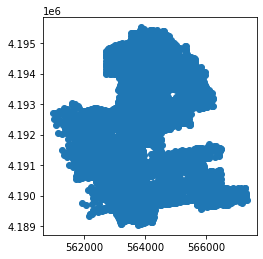

In [4]:
parcels_gdf = gpd.read_file("../outdata/berkeley_parcels_gdf_limited.json", driver="GeoJSON")
parcels_gdf.plot()

In [5]:
parcels_gdf.shape

(7309, 21)

#### Load the BART Station Data

If we look inside our data folder we see a `bart.csv` file. Let's check it out.

In [6]:
!ls ../qgis_workshop_data/

BerkeleyBikeBlvds.geojson        CaliforniaCounties.shx
BerkeleyCityLimits.zip           alco_schools.csv
BerkeleyNLCD2011.tif             bart.csv
CaliforniaCounties.dbf           calcounty_pop2017.csv
CaliforniaCounties.prj           cb_2018_06_place_500k.zip
CaliforniaCounties.shp           parcel_pts_rand30pct.geojson
CaliforniaCounties.shp.xml       parcel_pts_rand30pct.geojson.zip


Since this is a CSV file and not a shapefile or another geographic file format, we will read it in with pandas to a dataframe.

In [7]:
# Read in bart stations
# Read in CSV file
df = pd.read_csv("../qgis_workshop_data/bart.csv")
df.head()

,lon,lat,STATION,OPERATOR,COUNTY
0,-122.283348,37.874061,NORTH BERKELEY,BART,ALA
1,-122.268250,37.869689,DOWNTOWN BERKELEY,BART,ALA
2,-122.270119,37.853207,ASHBY,BART,ALA
3,-122.251777,37.844510,ROCKRIDGE,BART,ALA
4,-122.267120,37.828705,MACARTHUR,BART,ALA


It's a common workflow to get point data in a CSV file. 

Then we convert it to a geodataframe by identifying the columns that contain the point geometry.

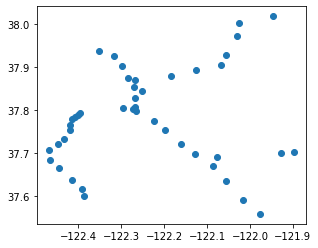

In [36]:
#Convert the DataFrame to a GeoDataFrame. 
bart_gdf = gpd.GeoDataFrame( df, geometry=gpd.points_from_xy(df.lon, df.lat)) 

# and take a look
bart_gdf.plot();

That looks odd... let's switch the lat and longitudes.

In [37]:
# Take a look 
bart_gdf.head()

,lon,lat,STATION,OPERATOR,COUNTY,geometry
0,-122.283348,37.874061,NORTH BERKELEY,BART,ALA,POINT (-122.28335 37.87406)
1,-122.268250,37.869689,DOWNTOWN BERKELEY,BART,ALA,POINT (-122.26825 37.86969)
2,-122.270119,37.853207,ASHBY,BART,ALA,POINT (-122.27012 37.85321)
3,-122.251777,37.844510,ROCKRIDGE,BART,ALA,POINT (-122.25178 37.84451)
4,-122.267120,37.828705,MACARTHUR,BART,ALA,POINT (-122.26712 37.82871)


Since a CSV file doesn't have a CRS we need to define it.

In [38]:
# Check it out
print("Here is our CRS after reading in the CSV file: ", bart_gdf.crs)

# Define the CRS
bart_gdf.crs = 'epsg:4326'

# Check it out
print("Here is our CRS now: ", bart_gdf.crs)


Here is our CRS after reading in the CSV file:  None
Here is our CRS now:  epsg:4326


### Step 2. Define Walking distance

Our goal is to add to the `permit_gdf` geodataframe a column with the number of BART stations within walking distance.

The first step in doing this is to define walking distance. We can read the planning literature for ideas but let's assume for this exercise that it is 500 meters, which is about 1/3 mile.

In [39]:
walking_distance_meters = 500;  # setting walking distance initially to 500 meters

### Step 3. Prepare data for Buffer Analysis

In order to create buffer polygons around our permit locations we need to transform our permit geodataframe to a 2D CRS where the units set are meters.  If you recall from our first Geopandas lesson there are a number of these CRSs for California.

Let's use the `California Albers CRS, NAD83 (epsg:3310`) since that can be used for any city in CA.


Now check the CRS of the permits geodataframe.

In [40]:
parcels_gdf.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 126°W to 120°W - by country
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Create a new permits geodataframe that has the CRS 3310.

In [41]:
parcels_3310 = parcels_gdf.to_crs('epsg:3310')

Now that we've transformed, or reprojected, the permit data, let's plot it. Notice the different coordinate values.

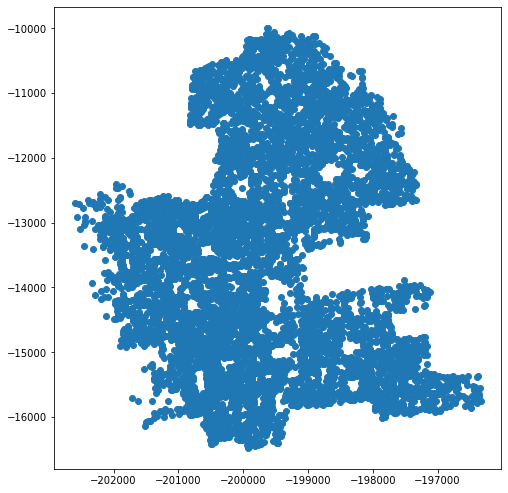

In [42]:
parcels_3310.plot(figsize=(8,10)) # note the different coordinate values - no longer lat/lon!
plt.show()

Ok, now create a new version of the bart data with the CAL Albers CRS (3310)

In [43]:
# transform the crS
bart_3310 = bart_gdf.to_crs('epsg:3310')

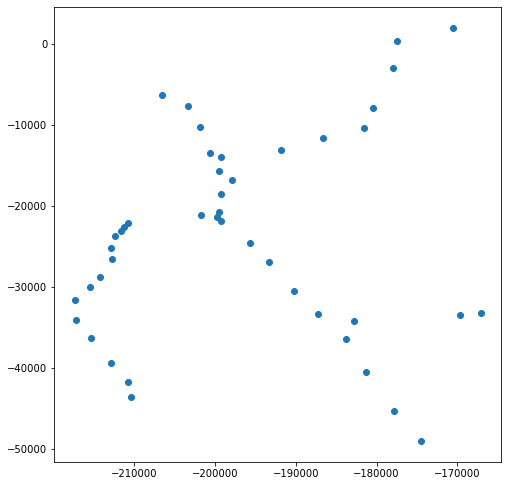

In [44]:
bart_3310.plot(figsize=(8,10)) # note the different coordinate values - no longer lat/lon!
plt.show()

In [45]:
# Take a look at the geodataframe
bart_3310.head()

,lon,lat,STATION,OPERATOR,COUNTY,geometry
0,-122.283348,37.874061,NORTH BERKELEY,BART,ALA,POINT (-200562.823 -13404.240)
1,-122.268250,37.869689,DOWNTOWN BERKELEY,BART,ALA,POINT (-199248.502 -13921.931)
2,-122.270119,37.853207,ASHBY,BART,ALA,POINT (-199456.560 -15749.735)
3,-122.251777,37.844510,ROCKRIDGE,BART,ALA,POINT (-197868.302 -16754.789)
4,-122.267120,37.828705,MACARTHUR,BART,ALA,POINT (-199258.276 -18479.109)


### Step 4.  Create Buffer Polygons

With that we can go on to actually making our buffers around the BART Stations that have the `walking distance` as the radius. We do this with the Geopandas geodataframe `.buffer()` method.

In [46]:
# Make sure
bart_3310 = bart_gdf.to_crs('epsg:3310')

bart_buf = bart_3310.buffer(distance=walking_distance_meters)

Now let's map the output.

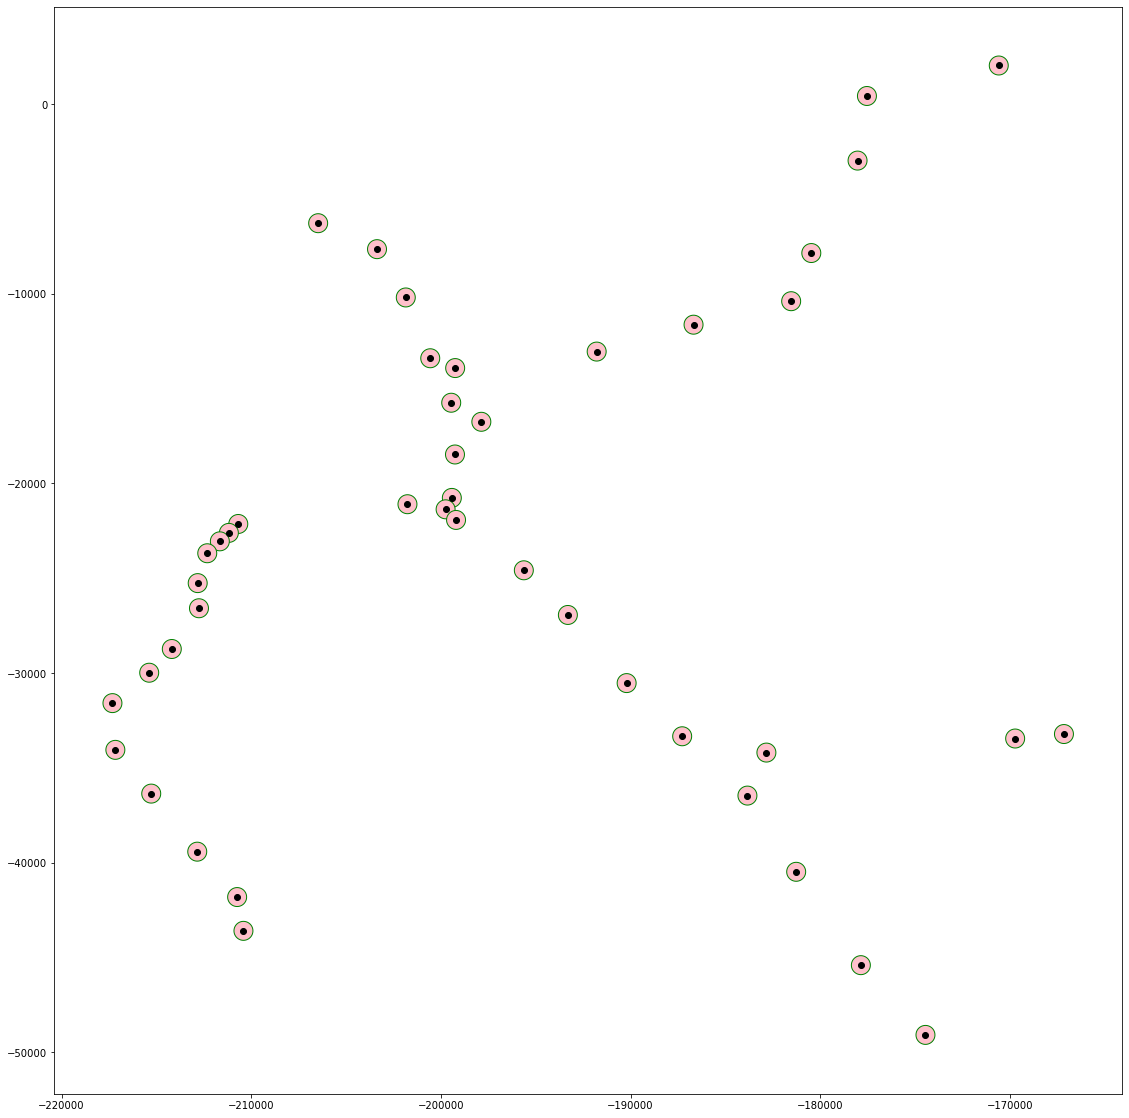

In [47]:
fig, ax = plt.subplots(figsize=(20,20))
bart_buf.plot(ax=ax, color="pink", edgecolor="green")
bart_3310.plot(ax=ax, color='black')
plt.show()

Let's add the permit points to the map

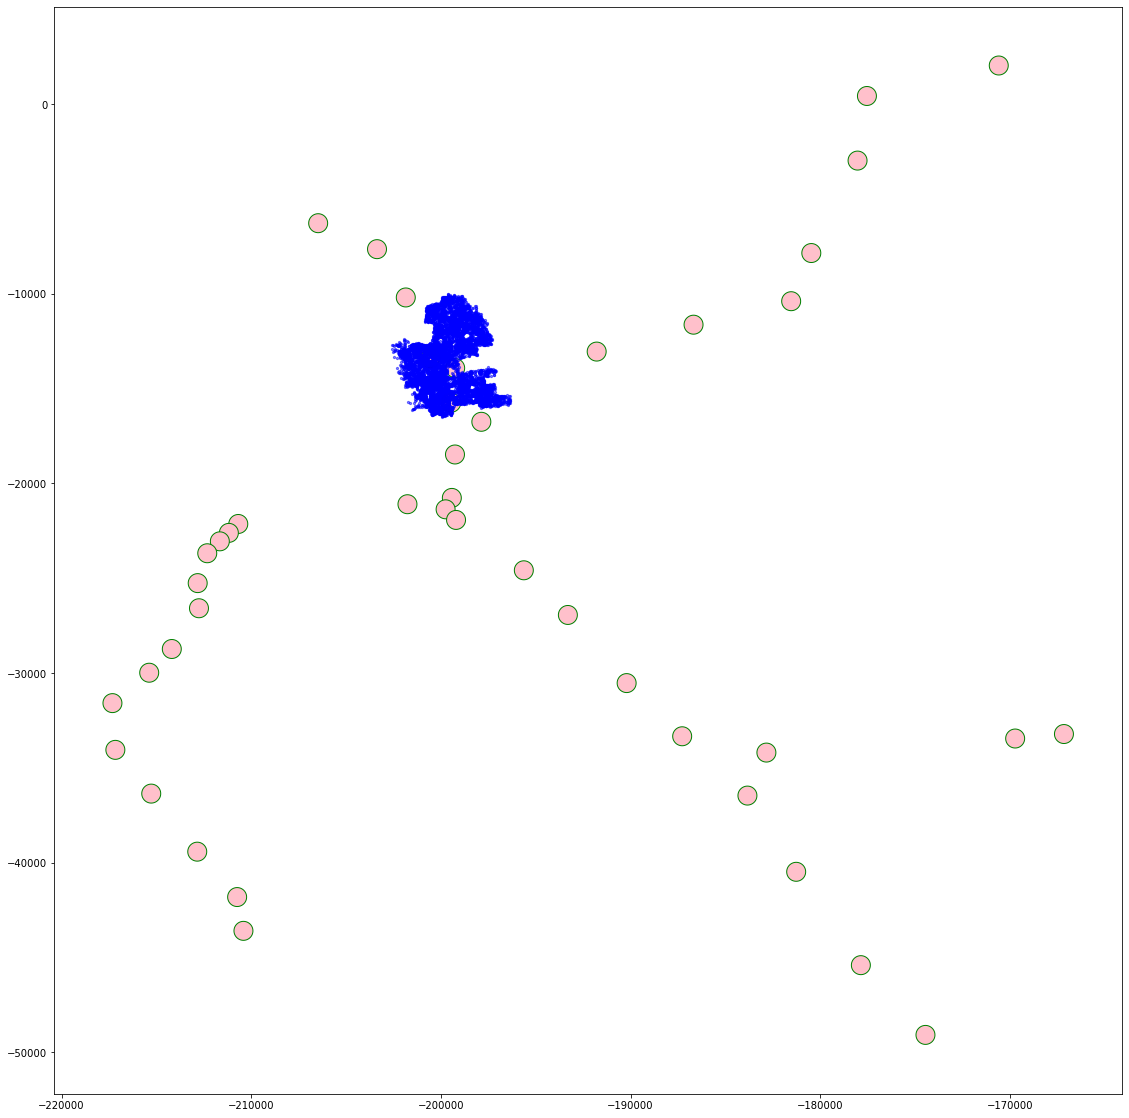

In [20]:
# Map it
fig, ax = plt.subplots(figsize = (20,20)) 

# Display the buffer output
bart_buf.plot(ax=ax,color="pink", edgecolor="green")

# Overlay the permit points
parcels_3310.plot(ax=ax, color="blue", alpha=0.5, markersize=5)

plt.show()

You can see from the map above that each BART station now has a buffer polygon.

You also get a sense that some but not all permit locations are near Bart stations.

Let's take a quick look at the data in the buffer output `bart_buf`.

In [48]:
bart_buf.head()

0    POLYGON ((-200062.823 -13404.240, -200065.231 ...
1    POLYGON ((-198748.502 -13921.931, -198750.910 ...
2    POLYGON ((-198956.560 -15749.735, -198958.968 ...
3    POLYGON ((-197368.302 -16754.789, -197370.710 ...
4    POLYGON ((-198758.276 -18479.109, -198760.684 ...
dtype: geometry

What type of data is that?

In [49]:
type(bart_buf)

geopandas.geoseries.GeoSeries

The output of the `buffer` operation is a Geopandas `GeoSeries` NOT a geodataframe. Before we can proceed we need to create a geodataframe.

We can create a geodataframe by combining a few key columns from the permit data with the buffer geometry.

In [51]:
# Create a permit_buf geodataframe
bart_buf_gdf = gpd.GeoDataFrame(data=bart_3310[['STATION']],
                                  geometry=bart_buf)

In [52]:
# Take a look at our permit buffer geodataframe
bart_buf_gdf.head()

,STATION,geometry
0,NORTH BERKELEY,"POLYGON ((-200062.823 -13404.240, -200065.231 ..."
1,DOWNTOWN BERKELEY,"POLYGON ((-198748.502 -13921.931, -198750.910 ..."
2,ASHBY,"POLYGON ((-198956.560 -15749.735, -198958.968 ..."
3,ROCKRIDGE,"POLYGON ((-197368.302 -16754.789, -197370.710 ..."
4,MACARTHUR,"POLYGON ((-198758.276 -18479.109, -198760.684 ..."


Nice work! We now have a geodataframe with all of our bart 500m buffer polygons and our permit geodataframe.

<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>
How would you go from a buffer polygon geodataframe back to a point geodataframe?

In [53]:
# Write your thoughts

Next we want to join them so that we can identify the permits that are within walking distance of BART.

In order to be able to identify those permits after our `spatial join` we first want to create a new variable called `bart_count`. Since each row is for one Bart station, we're going to set our variable to 1 for every entry.  

> This type of variable is often called a `dichotomous variable`, `binary variable` or `dummy_variable`.

In [54]:
bart_buf_gdf['bart_count'] = 1
bart_buf_gdf.head(5)

,STATION,geometry,bart_count
0,NORTH BERKELEY,"POLYGON ((-200062.823 -13404.240, -200065.231 ...",1
1,DOWNTOWN BERKELEY,"POLYGON ((-198748.502 -13921.931, -198750.910 ...",1
2,ASHBY,"POLYGON ((-198956.560 -15749.735, -198958.968 ...",1
3,ROCKRIDGE,"POLYGON ((-197368.302 -16754.789, -197370.710 ...",1
4,MACARTHUR,"POLYGON ((-198758.276 -18479.109, -198760.684 ...",1


# SEPARATE INTO ANOTHER NOTEBOOK FOR SPATIAL JOINS??

### Step 5. Spatially join the Permit buffers and BART data

Great, now that we have our data in the right CRS with our new BART count variable, we're going to go ahead and identify the permit point locations within waking distance of a BART station.

To do that, we're going to do a **spatial join** using the geopandas **sjoin** function. 

In [55]:
help(gpd.sjoin)

Help on function sjoin in module geopandas.tools.sjoin:

sjoin(left_df, right_df, how='inner', op='intersects', lsuffix='left', rsuffix='right')
    Spatial join of two GeoDataFrames.
    
    Parameters
    ----------
    left_df, right_df : GeoDataFrames
    how : string, default 'inner'
        The type of join:
    
        * 'left': use keys from left_df; retain only left_df geometry column
        * 'right': use keys from right_df; retain only right_df geometry column
        * 'inner': use intersection of keys from both dfs; retain only
          left_df geometry column
    op : string, default 'intersects'
        Binary predicate, one of {'intersects', 'contains', 'within'}.
        See http://shapely.readthedocs.io/en/latest/manual.html#binary-predicates.
    lsuffix : string, default 'left'
        Suffix to apply to overlapping column names (left GeoDataFrame).
    rsuffix : string, default 'right'
        Suffix to apply to overlapping column names (right GeoDataFrame).



Before proceeding, consider this:

- What geodataframe should be listed first in the spatial join as the `left_df`? Why does this matter?
- Do we want to do a default inner join or a left join?
- What will the output geometry type be? What do we want it to be?



<img align="left" width=500 src="https://upload.wikimedia.org/wikipedia/commons/f/ff/Cat_on_laptop_-_Just_Browsing.jpg"></img>


OK, spatial join time!

In [58]:
# Join the bart data to the permit data to identify permit locations near bart
parcels_near_bart_gdf = gpd.sjoin(parcels_3310,bart_buf_gdf)
parcels_near_bart_gdf.head()

,level_0,index,APN,APN2,STATE,COUNTY,FIPS,SIT_HSE_NU,SIT_DIR,SIT_STR_NA,...,SIT_ZIP,SIT_ZIP4,LAND_VALUE,IMPR_VALUE,TOT_VALUE,totvalue2,geometry,index_right,STATION,bart_count
125,393,26551,52-1527-1-4,052 152700104,CA,Alameda,06001,1896,None,Alcatraz,...,94703,2727,165191,373210,539995,539995,POINT (-199399.389 -16245.341),2,ASHBY,1
132,400,26558,52-1528-13,052 152801300,CA,Alameda,06001,1837,None,Alcatraz,...,94703,2714,310000,500000,810000,810000,POINT (-199476.307 -16199.155),2,ASHBY,1
133,401,26559,52-1528-17-2,052 152801702,CA,Alameda,06001,3253,None,Adeline,...,94703,2486,278754,2232730,480447,480447,POINT (-199517.427 -16169.371),2,ASHBY,1
134,402,26560,52-1528-24,052 152802400,CA,Alameda,06001,1900,None,Harmon,...,94703,2725,101838,254638,356476,356476,POINT (-199433.149 -16156.264),2,ASHBY,1
135,403,26561,52-1529-1,052 152900100,CA,Alameda,06001,1934,None,Fairview,...,94703,2719,57555,134295,184850,184850,POINT (-199352.683 -16017.788),2,ASHBY,1


<img align="left" width=500 src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Sad_Lucy.jpg/640px-Sad_Lucy.jpg"></img>

In [62]:
parcels_near_bart_gdf = gpd.sjoin(parcels_3310, bart_buf_gdf)
parcels_near_bart_gdf.head()

,level_0,index,APN,APN2,STATE,COUNTY,FIPS,SIT_HSE_NU,SIT_DIR,SIT_STR_NA,...,SIT_ZIP,SIT_ZIP4,LAND_VALUE,IMPR_VALUE,TOT_VALUE,totvalue2,geometry,index_right,STATION,bart_count
125,393,26551,52-1527-1-4,052 152700104,CA,Alameda,06001,1896,None,Alcatraz,...,94703,2727,165191,373210,539995,539995,POINT (-199399.389 -16245.341),2,ASHBY,1
132,400,26558,52-1528-13,052 152801300,CA,Alameda,06001,1837,None,Alcatraz,...,94703,2714,310000,500000,810000,810000,POINT (-199476.307 -16199.155),2,ASHBY,1
133,401,26559,52-1528-17-2,052 152801702,CA,Alameda,06001,3253,None,Adeline,...,94703,2486,278754,2232730,480447,480447,POINT (-199517.427 -16169.371),2,ASHBY,1
134,402,26560,52-1528-24,052 152802400,CA,Alameda,06001,1900,None,Harmon,...,94703,2725,101838,254638,356476,356476,POINT (-199433.149 -16156.264),2,ASHBY,1
135,403,26561,52-1529-1,052 152900100,CA,Alameda,06001,1934,None,Fairview,...,94703,2719,57555,134295,184850,184850,POINT (-199352.683 -16017.788),2,ASHBY,1


Before diving too deep into our results. We can start by double checking the shape of our input and output geodataframes to make sure they seem reasonable.

In [66]:
print("Number of parcel buffers",len(parcels_3310))
print("Number of BART stations:",len(bart_buf_gdf))
print("Number of pracels in BART bufs",len(parcels_near_bart_gdf))

Number of parcel buffers 7309
Number of BART stations: 44
Number of pracels in BART bufs 709



### Step 6. Count the number of Bart Stations within walking Distance of Permit Locations

Now that we have done our spatial join, we can sum the count of BART stations within walking distance of permit locations. We will dissolve duplicate geometries that share the same `jurisdiction_id`, assuming this to be a unique ID for the permit applications.

In [74]:
# Need to double check that the 'APN2' is the unique identifier
parcels_bart_counts_gdf = parcels_near_bart_gdf[['APN2','geometry','bart_count']].dissolve(by='APN2', aggfunc="sum", as_index=False)
parcels_bart_counts_gdf

,APN2,geometry,bart_count
0,052 152700104,POINT (-199399.389 -16245.341),1
1,052 152801300,POINT (-199476.307 -16199.155),1
2,052 152801702,POINT (-199517.427 -16169.371),1
3,052 152802400,POINT (-199433.149 -16156.264),1
4,052 152900100,POINT (-199352.683 -16017.788),1
...,...,...,...
704,059 228614100,POINT (-200560.292 -13004.833),1
705,059 228614200,POINT (-200561.546 -12991.637),1
706,059 228614500,POINT (-200563.969 -12950.836),1
707,059 228614600,POINT (-200564.971 -12936.944),1


We can combine this output with our sjoin input permit geodataframe (`parcels_3310`) to enhance the permit information.

In [75]:
parcels_gdf_enhanced = parcels_3310.merge(parcels_bart_counts_gdf[['APN2','bart_count']], on="APN2", how="left")


In [76]:
# Take a look
parcels_gdf_enhanced.sort_values(by="bart_count", ascending=False).head()

,level_0,index,APN,APN2,STATE,COUNTY,FIPS,SIT_HSE_NU,SIT_DIR,SIT_STR_NA,...,SIT_CITY,SIT_STATE,SIT_ZIP,SIT_ZIP4,LAND_VALUE,IMPR_VALUE,TOT_VALUE,totvalue2,geometry,bart_count
125,393,26551,52-1527-1-4,052 152700104,CA,Alameda,06001,1896,None,Alcatraz,...,Berkeley,CA,94703,2727,165191,373210,539995,539995,POINT (-199399.389 -16245.341),1.0
3369,3637,29795,57-2077-8,057 207700800,CA,Alameda,06001,1414,None,Delaware,...,Berkeley,CA,94702,1521,27133,17763,37896,37896,POINT (-200599.756 -13563.709),1.0
3614,3882,30040,58-2133-6,058 213300600,CA,Alameda,06001,1262,None,Virginia,...,Berkeley,CA,94702,1338,19715,14249,26964,26964,POINT (-201044.728 -13415.023),1.0
3615,3883,30041,58-2133-7,058 213300700,CA,Alameda,06001,1298,None,Virginia,...,Berkeley,CA,94702,1338,18934,22057,33991,33991,POINT (-201033.025 -13413.529),1.0
3616,3884,30042,58-2133-8,058 213300800,CA,Alameda,06001,1706,None,Chestnut,...,Berkeley,CA,94702,1432,121874,284373,399247,399247,POINT (-201037.645 -13429.727),1.0


In [78]:
parcels_gdf_enhanced.shape

(7309, 22)

Now let's use `value_counts` to check the distribution of values in the `bart_count` column.

In [79]:
parcels_gdf_enhanced.bart_count.value_counts(dropna=False)

NaN    6600
1.0     709
Name: bart_count, dtype: int64

You can see above that after the merge the `bart_count` column is NaN (not a number/null) for permit locations that were not within walking distance to BART.

We can use the `fillna()` method to set those values to zero.

In [80]:
parcels_gdf_enhanced.bart_count.fillna(0, inplace=True)

# And check the counts again
parcels_gdf_enhanced.bart_count.value_counts(dropna=False)

0.0    6600
1.0     709
Name: bart_count, dtype: int64

Phew! now let's map our output. The ultimate sanity check.

In [85]:
parcels_3310.total_bounds

array([-202599.02559495,  -16476.8795222 , -196335.89760897,
         -9993.11583203])

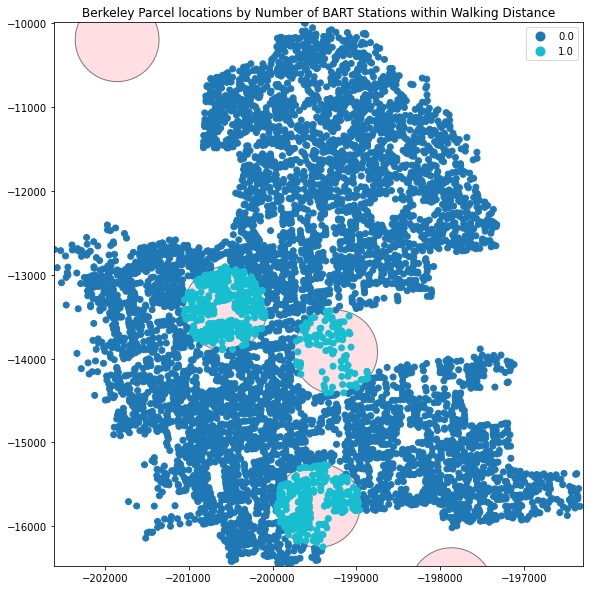

In [89]:
# Map it
fig, ax = plt.subplots(figsize = (10,10)) 

# Display the buffer output in PINK
bart_buf_gdf.plot(ax=ax, edgecolor="black",color="pink", alpha=0.5)

# Overlay the bart points in RED
parcels_gdf_enhanced.sort_values(by="bart_count").plot(ax=ax, column='bart_count', categorical=True, legend=True)

# Set x and y limits to zoom into Berkeley
ax.set_xlim([-202600,-196300])
ax.set_ylim([-16470,-9990])

ax.set_title('Berkeley Parcel locations by Number of BART Stations within Walking Distance')
plt.show()

# INCLUDE IN LATER NOTEBOOK?

<a id="section3"></a>
## 5.3. Exploratory Analysis

Once you have enhanced your spatial data the next step is to explore relationships and build and test hypothesis about the data.

For example, let's explore whether or not these locations are in census tracts with a high number of approved units.

First, let's read in the tract polygon with permit data file that we created in a previous lesson.

In [ ]:
# Read in census tract ACS data with joined permit data
tracts_with_permits = gpd.read_file("../notebook_data/outdata/tracts_and_permits_gdf.json", drive="GeoJSON")

As we did in a previous lesson, let's sum the number of approved permit units by census tract

In [ ]:
tract_permit_counts_gdf=tracts_with_permits[['GEOID','geometry','units_permit']].dissolve(by='GEOID', aggfunc="sum", as_index=False)
tract_permit_counts_gdf

And let's plot it to see what we have

In [ ]:
fig, ax = plt.subplots(figsize = (24,12)) 

# Display the output of our spatial join
tract_permit_counts_gdf.plot(ax=ax,
                             column='units_permit', 
                             scheme="quantiles", 
                             cmap="YlGnBu",
                             edgecolor="grey",
                             legend=True,
                             legend_kwds={'title': "Permitted units by Tract"}
                            )



plt.show()

Now we can create a map that allows us to explore the relationship between BART stations and permitted units.

> Take a close look at how we add the permits data. What's new here?

In [ ]:
fig, ax = plt.subplots(figsize = (24,12)) 

# Display the output of our spatial join
tract_permit_counts_gdf.plot(ax=ax,
                             column='units_permit', 
                             scheme="quantiles", 
                             cmap="YlGnBu",
                             edgecolor="grey",
                             legend=True,
                             legend_kwds={'title': "Permitted units by Tract"}
                             )

# Add permit locs within walking distance to bart
permits_gdf_enhanced.to_crs(tract_permit_counts_gdf.crs).sort_values(by="bart_count").plot(ax=ax, 
                                                            column='bart_count', 
                                                            edgecolor='grey', 
                                                            legend=True, 
                                                            cmap='Reds',
                                                            markersize=25,
                                                            legend_kwds={'label': "Count of BART Stations w/in Walking Distance"}
                                                            )


ax.set_title("Oakland Permit Application Data")
plt.show()

<div style="display:inline-block;vertical-align:top;">
    <img src="https://image.flaticon.com/icons/svg/87/87705.svg" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

Does there appear to be a relationship between the number of nearby BART stations and the number of permitted units?

<a id="section4"></a>
## 5.4 Recap
In this notebook we answered the question "How many BART stations are within walking distance from a permit?" and "What is the relationship between the number of approved permits and walkable BART stations for a tract?" We learned how to create buffer and overlay points over a choropleth map. We also revisited how to create an interactive map

Below you'll find a list of key functionalities we learned and practiced:
- Create a buffer of specified size
    - `.buffer()`
- Spatial joins
    - `.sjoin()`

---
<a id="section5"></a>
## 5.5 Homework

####  Exercise

Do another buffer analysis, this time use any of the following data that you find in the folders:

>`notebook_data/transportation`
> - `sfmta_stations.zip` - SF MTA station locations
> - `regional_bike_facilities.zip` - Off-street shared use path, bike lanes, and on-street bike routes
> - `baywheels_stations.zip` - Baywheel station locations

> `notebook_data/other`
> - `ca_grocery_stores_2019_wgs84.zip` - Grocery store locations

You'll need to execute the following steps:
1. Load the data and check the columns, geometry type and CRS
2. Check and update the crs if needed
3. Spatially join your dataset with the buffer polygons of the permits data
4. Dissolve and aggregate the values of interest
5. Join the data back to the parcels dataset
6. Replace null values with zero
7. Map the results

In [ ]:
# Your code here

*Click here for answers*

<!---
    # SOLUTION
    # Load the data and check the columns, geometry type and CRS
    baywheels_stations_gdf = gpd.read_file("zip://../notebook_data/transportation/baywheels_stations.zip")
    # Check and update the crs if needed
    baywheels_3310 = baywheels_stations_gdf.to_crs('epsg:3310')
    baywheels_3310['bike_count_dv'] = 1
    baywheels_3310.head()

    # SOLUTION

    # Spatially join your dataset with the buffer polygons of the permits data
    permit_buf_bike_gdf = gpd.sjoin(permit_buf_gdf, baywheels_3310)
    permit_buf_bike_gdf.head()

    # Dissolve and aggregate the values of interest
    permit_bike_counts_gdf=permit_buf_bike_gdf[['jurisdiction_id','geometry','bike_count_dv']].dissolve(by='jurisdiction_id', aggfunc="sum", as_index=False)
    permit_bike_counts_gdf.head()
    permit_bike_counts_gdf.shape

    # Join the data back to the permits dataset
    permits_gdf_enhanced = permits_gdf_enhanced.merge(permit_bike_counts_gdf[['jurisdiction_id','bike_count_dv']], on="jurisdiction_id", how="left")
    permits_gdf_enhanced.head()

    # SOLUTION

    # Replace null values with zero
    permits_gdf_enhanced['bike_count_dv'].fillna(0, inplace=True)
    permits_gdf_enhanced.head()

    # Map the results
    # Plot
    fig, ax = plt.subplots(figsize = (24,12)) 

    #Add permit locs within walking distance to bart
    permits_gdf_enhanced.sort_values(by="bike_count_dv").plot(ax=ax, 
                                                                column="bike_count_dv", 
                                                                edgecolor='grey', 
                                                                legend=True, 
                                                                cmap='Greens',
                                                                markersize=25)

    ax.set_title('Oakland Permit locations by Number of Bike Stations within Walking Distance')
    plt.show()

    # SOLUTION

    # Create an interactive map with your new data as a layer and check your results
    # Define the basemap
    buf_map = folium.Map(location=[37.809142, -122.268228],   # lat, lon around which to center the map
                     tiles='CartoDB Positron',
                     width=900,                        # the width & height of the output map
                     height=600,                       # in pixels
                     zoom_start=15)  

    # Add Bike Stations as Circle Markers - you can set radius
    for i in baywheels_stations_gdf.index:
        folium.Circle(
            location=[baywheels_stations_gdf['geometry'].y[i], baywheels_stations_gdf['geometry'].x[i]],
            radius= 500,
            popup= baywheels_stations_gdf['name'][i],
            color='green',
            fill=True,
            fill_color='green'
    ).add_to(buf_map)

    # Add Bike stations as Markers (default with GeoJson when data are points)
    folium.GeoJson(baywheels_stations_gdf,
                  tooltip=folium.GeoJsonTooltip(fields=['name' ], 
                       aliases=['Location'],
                       labels=True,
                       localize=True
                   ),
                  ).add_to(buf_map)

    # Add permit locations
    permits_gdf_enhanced.apply(lambda row: folium.Circle(location=[row['geometry'].y,row['geometry'].x],
                                      tooltip= row['bike_count_dv'],
                                      radius=5,
                                     ).add_to(buf_map),
                                 axis=1)

    buf_map.add_child(MeasureControl())

    buf_map # wait for it...
--->